# Airbnb User Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "
/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


I wanted to take a look at the user data we have for this competition so I made this little notebook to share my findings and discuss about those. At the moment I've started with the user data, I'll take a look at sessions and the other *csv* files later on this month.

Please, feel free to comment with anything you think it can be improved or fixed. I am not a professional in this field and there will be mistakes or things that can be *improved*. This is the flow I took and there are some plots not really interesting but I thought on keeping it in case someone see something interesting.

Let's see the data!

## Data Exploration

Generally, when I start with a Data Science project I'm looking to answer the following questions:
 - Is there any mistakes in the data?
 - Does the data have peculiar behavior?
 - Do I need to fix or remove any of the data to be more realistic?

In [2]:
# Load the data into DataFrames
train_users = pd.read_csv('../data/raw/train_users.csv')
test_users = pd.read_csv('../data/raw/test_users.csv')

It's usually a good practice to know the size of the data with which you are working:

In [3]:
print("We have", train_users.shape[0], "users in the training set and", 
      test_users.shape[0], "in the test set.")
print("In we have", train_users.shape[0] + test_users.shape[0], "users.")

We have 213451 users in the training set and 62096 in the test set.
In we have 275547 users.


Let's get those together so we can work with all the data.

In [4]:
# Merge train and test users
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

# Remove ID's since now we are not interested in making predictions
users.drop('id',axis=1, inplace=True)

users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


The data seems to be in an ussable format so the next important thing is to take a look at the missing data.

### Missing Data

Usually the missing data comes in the way of *NaN*, but if we take a look at the DataFrame printed above we can see at the `gender` column some values being `-unknown-`. We will need to transform those values into *NaN* first:

In [5]:
users.gender.replace('-unknown-', np.nan, inplace=True)

Now let's see how much data we are missing. For this purpose let's compute the NaN percentage of each feature.

In [6]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')

age                        42.412365
date_first_booking         67.733998
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

We have quite a lot of *NaN* in the `age` and `gender` wich will yield in lesser performance of the classifiers we will build. The feature `date_first_booking` has a 67% of NaN values because this feature is not present at the tests users, and therefore, we won't need it at the *modeling* part.

In [7]:
print("Just for the sake of curiosity; we have", 
      int((train_users.date_first_booking.isnull().sum() / train_users.shape[0]) * 100), 
      "% of missing values at date_first_booking in the training data")

Just for the sake of curiosity; we have 58 % of missing values at date_first_booking in the training data


The other feature with a high rate of *NaN* was `age`. Let's see:

In [8]:
users.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

There is some inconsistency in the age of some users as we can see above. It could be because the `age` inpout field was not sanitized or there was some mistakes handlig the data.

In [9]:
print(sum(users.age > 122))
print(sum(users.age < 18))

830
188


So far, do we have 830 users with [the longest confirmed human lifespan record](https://en.wikipedia.org/wiki/Jeanne_Calment) and 188 little *gangsters* breaking the [Aribnb Eligibility Terms](https://www.airbnb.com/terms)?

In [10]:
users[users.age > 122]['age'].describe()

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

It's seems that the weird values are caused by the appearance of 2014. I didn't figured why, but I supose that might be related with a wrong input being added with the new users.

In [11]:
users[users.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

The young users seems to be under an acceptable range being the 50% of those users above 16 years old. 
We will need to hande the outliers. The simple thing that came to my mind it's to set an acceptance range and put those out of it to NaN.

In [12]:
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

### Data Types

Let's treat each feature as what they are. This means we need to transform into categorical those features that we treas as categories and the same with the dates:

In [13]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')

In [14]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

### Visualizing the Data

Usually, looking at tables, percentiles, means, and other several measures at this state is rarely useful unless you know very well your data.

For me, it's usually better to visualize the data in some way. Visualization makes me see the outliers and errors immediately!

#### Gender

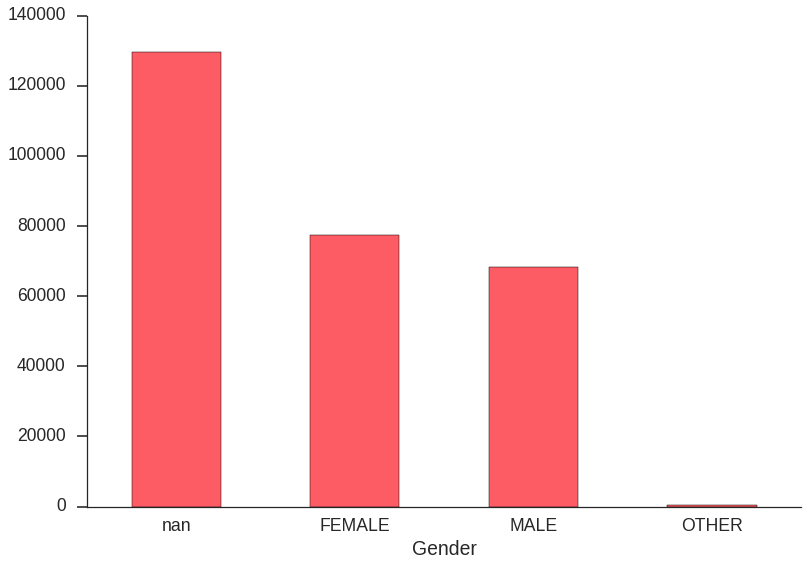

In [15]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()

As we've seen before at this plot we can see the ammount of missing data in perspective. Also, notice that there is a slight difference between user gender.

Next thing it might be interesting to see if there is any gender preferences when travelling:

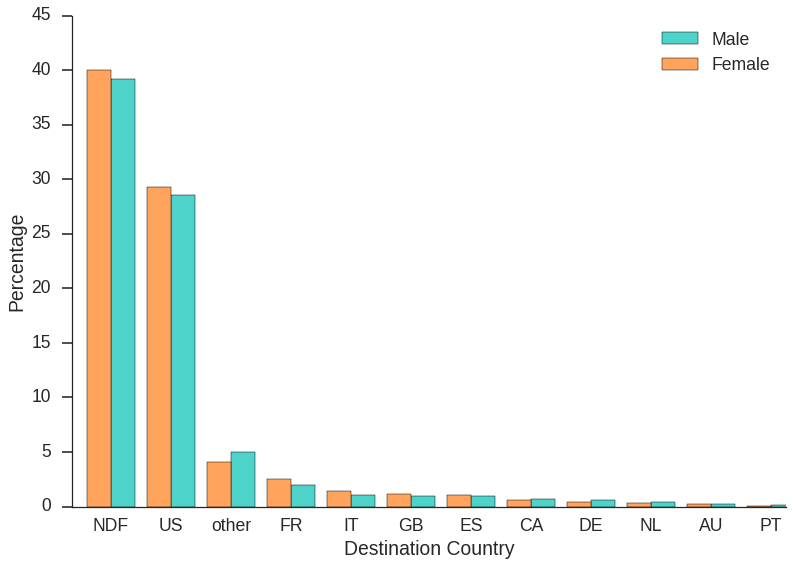

In [16]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

There are no big differences between the 2 main genders, so this plot it's not really ussefull except to know the relative destination frecuency of the countries. Let's see it clear here:

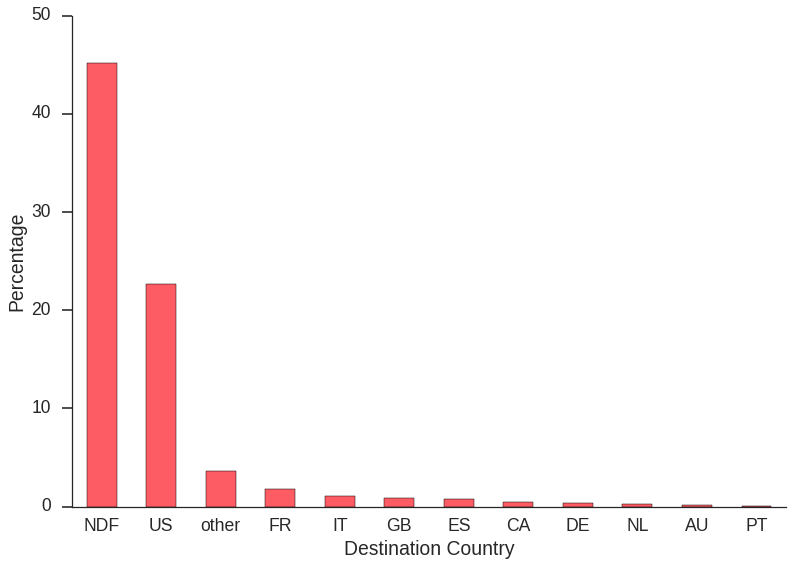

In [17]:
destination_percentage = users.country_destination.value_counts() / users.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)
# Using seaborn can also be plotted
# sns.countplot(x="country_destination", data=users, order=list(users.country_destination.value_counts().keys()))
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

The first thing we can see that if there is a reservation, it's likely to be inside the US. But there is a 45% of people that never did a reservation.

#### Age

Now that I know there is no difference between male and female reservations at first sight I'll dig into the age.

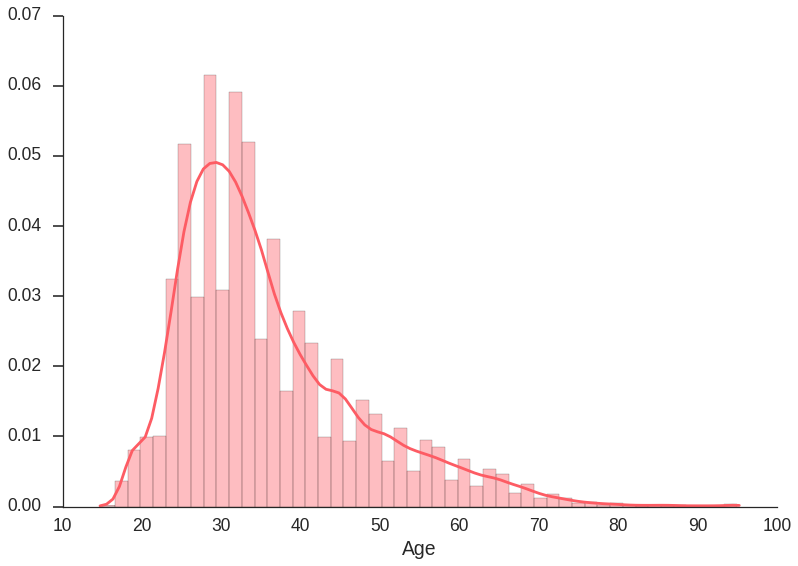

In [18]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

As expected, the common age to travel is between 25 and 40. Let's see if, for example, older people travel in a different way. Let's pick an arbitrary age to split into two groups. Maybe 45?

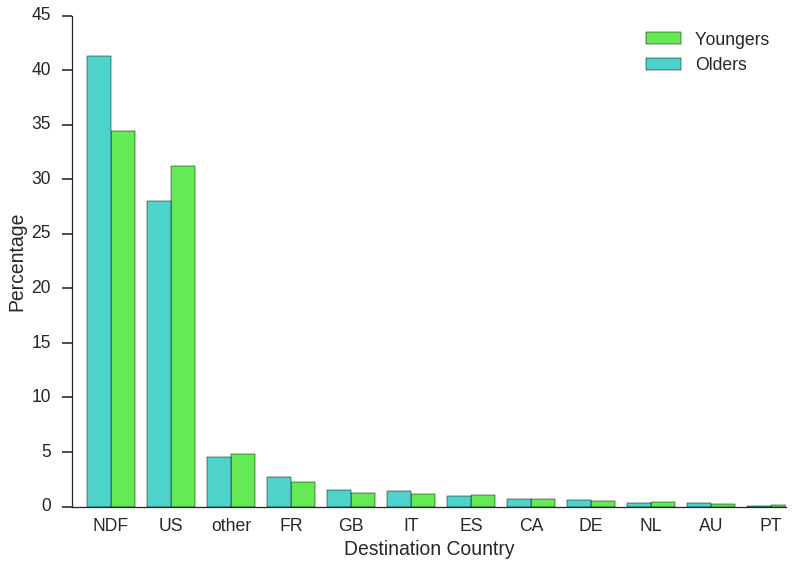

In [19]:
age = 45

younger = sum(users['age'] < age)
older = sum(users['age'] > age)

younger_destinations = users.loc[users['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = users.loc[users['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngers', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

We can see that the young people tends to stay in the US, and the older people choose to travel outside the country. Of vourse, there are no big differences between them and we must remember that we do not have the 42% of the ages. 

The first thing I thought when reading the problem was the importance of the native lenguage when choosing the destination country. So let's see how manny users use english as main language:

In [20]:
print((sum(users.language == 'en') / users.shape[0])*100)

96.3675888324


With the 96% of users using English as their language, it is understandable that a lot of people stay in the US. Someone maybe thinking, if the language is important, why not travel to GB? We need to remember that there is also a lot of factor we are not acounting so making assumpions or predictions like that might be dangerous.

#### Dates

To see the dates of our users and the timespan of them, let's plot the number of accounts created by time:

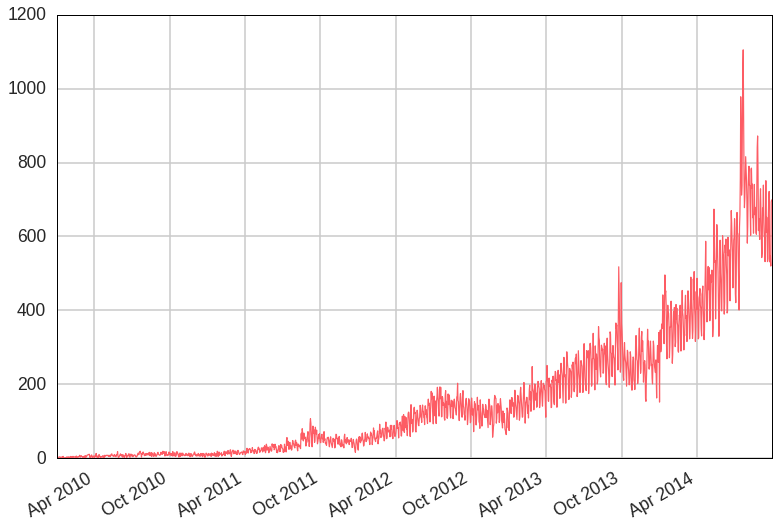

In [21]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

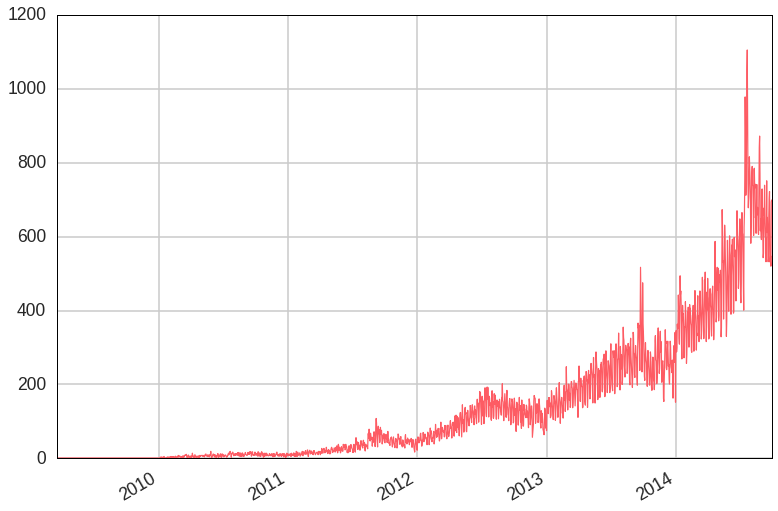

In [ ]:
users.date_first_active.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

In [ ]:
users_2013 = users[users['date_first_active'] > pd.to_datetime(20130101, format='%Y%m%d')]
users_2013 = users_2013[users_2013['date_first_active'] < pd.to_datetime(20140101, format='%Y%m%d')]
users_2013.date_first_active.value_counts().plot(kind='line', linewidth=2, color='#FD5C64')
plt.show()